# Generate tract-level attributes for WECC
### Author: Xiaodan Xu, LBNL

In [1]:
# load packages
import os
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shapely.wkt
import geopandas as gpd
import contextily as cx
import matplotlib
import warnings
from  matplotlib.ticker import PercentFormatter
from pygris import states
# from rasterio.crs import CRS
warnings.filterwarnings("ignore")
#work directory is where the I-O data are stored
work_dir = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/BILD-AQ/deliverables'
os.chdir(work_dir)

plt.style.use('ggplot')
sns.set(font_scale=1.4)  # larger font

<Axes: >

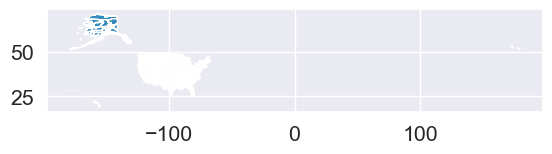

In [2]:
# prepare input and parameters
region_code = 'WECC'
# selected_states = ['CA', 'OR', 'WA']
dac_designation = read_csv('Network/Joint_office_DAC_lookup.csv')

state_id_file = 'Network/ccst_geoid_key_transp_geo_with_imputation.csv'
state_id_lookup = read_csv(state_id_file)

# power plant location (from McGrid
power_plant_file = 'Network/from_mcgrid/power_plants_coordinates.csv'
power_plant_location = read_csv(power_plant_file)

# generate map visualization
us_tract_file = 'Network/census_tracts_2017.geojson'
us_tracts_geojson =  gpd.read_file(us_tract_file) # load shapefile of CA tracts
us_tracts_geojson.loc[:, 'home_GEOID'] = us_tracts_geojson.loc[:, 'GEOID'].astype(int)
# CA_tracts_geojson.loc[:, 'home_GEOID'] = CA_tracts_geojson.loc[:, 'GEOID'].astype(str).str.zfill(0)
#CA_tracts_geojson.head(5)
us_tracts_geojson.plot()

In [3]:
# load TEMPO results

EV_penetration_by_scenario = None
# scenario_name_lookup = {'Baseline': 'Baseline', 'NEVI': 'NEVI'} 
#                         'Bookend': 'Bookend'}
analysis_year = 2030
# scenarios = ['Baseline', 'NEVI only', 'IRA only', 'NEVI and IRA']

scenarios = ['Baseline', 'NEVI']
EV_penetration_dir = 'Output/' + region_code + '/EV_penetration/'
list_of_ev_penetration = \
os.listdir('Output/' + region_code + '/EV_penetration')

for scenario in scenarios:
#     print(file)
    file_name = 'EV_penetration_' + region_code + '_' + \
    str(analysis_year) + '_' + scenario + '.csv'

    scenario_output = \
    'Year ' + str(analysis_year) + ' ' + scenario
#     print(scenario_output)
    ev_penetration = read_csv(EV_penetration_dir + '/' + file_name)
    ev_penetration.loc[:, 'Description'] = scenario_output
    ev_penetration.loc[:, 'Year'] = analysis_year
    ev_penetration.loc[:, 'Scenario'] = scenario

    EV_penetration_by_scenario = pd.concat([EV_penetration_by_scenario, 
                                            ev_penetration])
#     break
#     EV_penetration_by_scenario.head(5)    

EV_penetration_by_scenario.loc[:, 'EV_count'] = \
EV_penetration_by_scenario.loc[:, 'Total'] * \
(EV_penetration_by_scenario.loc[:, 'BEV_100'] + \
 EV_penetration_by_scenario.loc[:, 'BEV_300'] + \
 EV_penetration_by_scenario.loc[:, 'FCEV'] + \
EV_penetration_by_scenario.loc[:, 'PHEV_25'] + \
 EV_penetration_by_scenario.loc[:, 'PHEV_50'])

EV_penetration_by_scenario['EV_count'] = \
EV_penetration_by_scenario['EV_count'].astype(int)

WECC_states = EV_penetration_by_scenario.State.unique()
print(WECC_states)

print(EV_penetration_by_scenario.Scenario.unique())

EV_penetration_by_scenario.head(5)

['AZ' 'CA' 'CO' 'ID' 'MT' 'NM' 'NV' 'OR' 'UT' 'WA' 'WY']
['Baseline' 'NEVI']


,State,home_GEOID,BEV_100,BEV_300,FCEV,HEV_Gasoline,ICEV_Gasoline,ICEV_NG,PHEV_25,PHEV_50,Total,Description,Year,Scenario,EV_count
0,AZ,4001942600,0.030430,0.079748,0.0,0.007345,0.876180,0.000000,0.000000,0.006296,953,Year 2030 Baseline,2030,Baseline,110
1,AZ,4001942700,0.033924,0.082498,0.0,0.014649,0.858520,0.000000,0.000771,0.009638,2594,Year 2030 Baseline,2030,Baseline,328
2,AZ,4001944000,0.031050,0.087388,0.0,0.014405,0.861396,0.000000,0.000640,0.005122,3124,Year 2030 Baseline,2030,Baseline,387
3,AZ,4001944100,0.029270,0.086608,0.0,0.013232,0.867682,0.000000,0.000401,0.002807,2494,Year 2030 Baseline,2030,Baseline,296
4,AZ,4001944201,0.023256,0.085430,0.0,0.011865,0.872330,0.003797,0.000475,0.002848,2107,Year 2030 Baseline,2030,Baseline,235


# Part 1 - generate tract-level land use, demographic and network features

In [4]:
# select census tract in WECC region
state_id_lookup_WECC = state_id_lookup[['GEOID', 'fips_st',
       'st_code', 'state', 'cty', 'ctyname', 'geotype', 'microtype']]
state_id_lookup_WECC = \
state_id_lookup_WECC.loc[state_id_lookup_WECC['st_code'].isin(WECC_states)]

print(len(state_id_lookup_WECC))
state_id_lookup_WECC.head(5)

15570


,GEOID,fips_st,st_code,state,cty,ctyname,geotype,microtype
0,6037535001,6,CA,California,6037,"Los Angeles County, CA",A,1
1,6037535102,6,CA,California,6037,"Los Angeles County, CA",A,1
2,6037535101,6,CA,California,6037,"Los Angeles County, CA",A,1
3,6037535300,6,CA,California,6037,"Los Angeles County, CA",A,1
4,6037535200,6,CA,California,6037,"Los Angeles County, CA",A,1


In [5]:
# load additional land use and demographic data

# demographic data
acs_tract_data = \
read_csv(os.path.join('Network', 'from_GEMS', 'acs_data_tracts_2017.csv'))

# network data
hpms_network_data = \
read_csv(os.path.join('Network', 'from_GEMS', 'network_attributes.csv'))

# land area data
land_area_data = \
read_csv(os.path.join('Network', 'from_GEMS', 'combined_tract_land_area.csv'))

microtype_input_data = \
read_csv(os.path.join('Network', 'from_GEMS', 'microtypes_inputs.csv'))

In [6]:
# processing demographic data

acs_var = ['GEOID', 'populationE', 'householdsE', #total person and hh
           'whiteE', 'pop_16_aboveE', 'emp_unempE', #person level 
           'veh_0E', 'med_inc_npvE'] # hh level
acs_tract_data = acs_tract_data[acs_var]

acs_tract_data.loc[:, 'hh_no_veh'] = \
acs_tract_data.loc[:, 'veh_0E']/ acs_tract_data.loc[:, 'householdsE']

acs_tract_data.loc[:, 'person_non_white'] = \
1 - acs_tract_data.loc[:, 'whiteE']/ acs_tract_data.loc[:, 'populationE']

acs_tract_data.loc[:, 'unemp_rate'] = \
acs_tract_data.loc[:, 'emp_unempE']/ acs_tract_data.loc[:, 'pop_16_aboveE']

name_mapping = {'populationE': 'persons',
               'householdsE': 'households',
               'med_inc_npvE': 'hh_med_inc'}
acs_tract_data_out = \
acs_tract_data.rename(columns = name_mapping)
acs_tract_data_out = acs_tract_data_out[['GEOID', 'persons', 'households',
                                        'hh_med_inc', 'hh_no_veh', 'person_non_white',
                                        'unemp_rate']]
acs_tract_data_out.head(5)

,GEOID,persons,households,hh_med_inc,hh_no_veh,person_non_white,unemp_rate
0,1001020100,1845,754,67826.0,0.007958,0.113279,0.028321
1,1001020200,2172,783,41287.0,0.086845,0.579650,0.017699
2,1001020300,3385,1279,46806.0,0.114152,0.386115,0.027320
3,1001020400,4267,1749,55895.0,0.010292,0.193110,0.035778
4,1001020500,9965,4194,68143.0,0.070100,0.215554,0.014706


In [7]:
# processing land area and network data
print(hpms_network_data.columns)
network_attr = ['GEOID', 'lm_all_tract', 'pct_controlf', 
               'lm_tract_fsys1', 'lm_tract_fsys2', 'lm_tract_fsys3', 'lm_tract_fsys4', 
                'lm_tract_fsys5', 'lm_tract_fsys6', 'lm_tract_fsys7', 'aadt_tract']
hpms_network_data = hpms_network_data[network_attr]
hpms_network_data.loc[:, 'lanemile_highway'] = \
hpms_network_data.loc[:, 'lm_tract_fsys1'] + hpms_network_data.loc[:, 'lm_tract_fsys2']

hpms_network_data.loc[:, 'frac_highway'] = \
hpms_network_data.loc[:, 'lanemile_highway'] / \
hpms_network_data.loc[:, 'lm_all_tract']

hpms_network_data.loc[:, 'lanemile_arterial'] = \
hpms_network_data.loc[:, 'lm_tract_fsys3'] + hpms_network_data.loc[:, 'lm_tract_fsys4']

hpms_network_data.loc[:, 'frac_arterial'] = \
hpms_network_data.loc[:, 'lanemile_arterial'] / \
hpms_network_data.loc[:, 'lm_all_tract']

hpms_network_data.loc[:, 'lanemile_local'] = \
hpms_network_data.loc[:, 'lm_tract_fsys5'] + \
hpms_network_data.loc[:, 'lm_tract_fsys6'] + \
hpms_network_data.loc[:, 'lm_tract_fsys7']

hpms_network_data.loc[:, 'frac_local'] = \
hpms_network_data.loc[:, 'lanemile_local'] / \
hpms_network_data.loc[:, 'lm_all_tract']

hpms_mapping = {'aadt_tract': 'total_hpms_VMT',
               'lm_all_tract': 'total_hpms_lanemile',
               'pct_controlf': 'frac_of_full_control'}
hpms_network_out = hpms_network_data.rename(columns = hpms_mapping)
hpms_network_out = hpms_network_out[['GEOID', 'total_hpms_lanemile','total_hpms_VMT',
                                    'frac_of_full_control', 'lanemile_highway',
                                    'frac_highway', 'lanemile_arterial', 'frac_arterial',
                                    'lanemile_local', 'frac_local']]

# append land area
hpms_network_out = pd.merge(land_area_data, hpms_network_out, 
                            on = 'GEOID', how = 'left')
la_mapping = {'ALAND': 'land_area_m2',
             'AWATER': 'water_area_m2'}
hpms_network_out = hpms_network_out.rename(columns = la_mapping)
hpms_network_out.head(5)

Index(['GEOID', 'aland', 'awater', 'terrain_intensity', 'grade_mean',
       'pct_sigs_coord', 'signal_density', 'lm_tract_fsys1', 'lm_tract_fsys2',
       'lm_tract_fsys3', 'lm_tract_fsys4', 'lm_tract_fsys5', 'lm_tract_fsys6',
       'lm_tract_fsys7', 'state_code', 'avg_iri', 'lm_all_tract',
       'pct_controlf', 'pct_controlp', 'avg_speed_limit', 'pct_aadt_combi',
       'aadt_combi_per_lm', 'network_length_miles_fsys1',
       'network_length_miles_fsys2', 'network_length_miles_fsys3',
       'network_length_miles_fsys4', 'network_length_miles_fsys5',
       'network_length_miles_fsys6', 'network_length_miles_fsys7',
       'aadt_tract', 'sys_length_tract', 'vmt_combi_tract',
       'vmt_single_tract'],
      dtype='object')


,GEOID,land_area_m2,water_area_m2,total_hpms_lanemile,total_hpms_VMT,frac_of_full_control,lanemile_highway,frac_highway,lanemile_arterial,frac_arterial,lanemile_local,frac_local
0,25027724100,53034202,1639215,62.400433,144328.0900,0.000000,0.00000,0.000000,33.149466,0.531238,29.250965,0.468762
1,25027759100,25570219,1427831,49.401062,149778.3600,0.000000,0.00000,0.000000,26.953263,0.545601,22.447800,0.454399
2,25025091300,262560,0,3.594611,5911.6973,0.000000,0.00000,0.000000,1.832486,0.509787,1.762125,0.490213
3,25025110501,647837,0,7.637373,41926.0700,0.000000,0.00000,0.000000,3.573701,0.467923,4.063672,0.532077
4,25025030500,193673,292691,6.620325,70471.2730,0.426348,2.82256,0.426348,3.797765,0.573652,0.000000,0.000000


In [8]:
# compile all WECC data
DAC_boundary = dac_designation[['GEOID', 'NEVI_DAC']]

# append acs data
state_id_lookup_WECC = state_id_lookup_WECC.drop_duplicates(keep = 'first')
state_id_lookup_WECC = pd.merge(state_id_lookup_WECC,
                                acs_tract_data_out,
                                on = 'GEOID',
                                how = 'left')
# append network and land area data
state_id_lookup_WECC = pd.merge(state_id_lookup_WECC,
                                hpms_network_out,
                                on = 'GEOID',
                                how = 'left')

# append DAC boundary
state_id_lookup_WECC = pd.merge(state_id_lookup_WECC,
                                DAC_boundary,
                                on = 'GEOID',
                                how = 'left')
print(state_id_lookup_WECC.columns)
state_id_lookup_WECC.head(5)

Index(['GEOID', 'fips_st', 'st_code', 'state', 'cty', 'ctyname', 'geotype',
       'microtype', 'persons', 'households', 'hh_med_inc', 'hh_no_veh',
       'person_non_white', 'unemp_rate', 'land_area_m2', 'water_area_m2',
       'total_hpms_lanemile', 'total_hpms_VMT', 'frac_of_full_control',
       'lanemile_highway', 'frac_highway', 'lanemile_arterial',
       'frac_arterial', 'lanemile_local', 'frac_local', 'NEVI_DAC'],
      dtype='object')


,GEOID,fips_st,st_code,state,cty,ctyname,geotype,microtype,persons,households,...,total_hpms_lanemile,total_hpms_VMT,frac_of_full_control,lanemile_highway,frac_highway,lanemile_arterial,frac_arterial,lanemile_local,frac_local,NEVI_DAC
0,6037535001,6,CA,California,6037,"Los Angeles County, CA",A,1,4436,1024,...,6.840630,39543.535,0.0,0.0,0.0,5.360394,0.783611,1.480236,0.216389,1.0
1,6037535102,6,CA,California,6037,"Los Angeles County, CA",A,1,4939,1101,...,5.374996,41697.316,0.0,0.0,0.0,5.374995,1.000000,0.000000,0.000000,1.0
2,6037535101,6,CA,California,6037,"Los Angeles County, CA",A,1,7920,1799,...,9.967542,72765.164,0.0,0.0,0.0,9.966152,0.999861,0.001389,0.000139,1.0
3,6037535300,6,CA,California,6037,"Los Angeles County, CA",A,1,6003,1451,...,10.231982,67561.375,0.0,0.0,0.0,9.279923,0.906953,0.952059,0.093047,1.0
4,6037535200,6,CA,California,6037,"Los Angeles County, CA",A,1,6102,1344,...,3.427306,17938.914,0.0,0.0,0.0,2.908035,0.848490,0.519271,0.151510,1.0


In [9]:
print(len(state_id_lookup_WECC))
out_file_name = 'WECC_land_network_demo_attr.csv'
state_id_lookup_WECC.to_csv(os.path.join('Network', out_file_name), index = False)

15570


# Part 2 - generate Vehicle ownership and VMT by home tracts

In [5]:
NAVIGAT_VMT_output = None

path_to_vmt = os.path.join('Input', region_code, 'NAVIGAT')
vmt_folders = os.listdir(path_to_vmt)
for folder in vmt_folders:
    print(folder)
    if folder == '.DS_Store' or folder.endswith('csv'):
        continue
    path_to_results = os.path.join(path_to_vmt, folder)
    file_name = 'BILDAQ_VMT_by_tract_multistate_spillover.csv'
    vmt_by_state = read_csv(os.path.join(path_to_results, file_name))
    vmt_by_state = vmt_by_state[['thru_GEOID', 'home_GEOID', 
                                 'populationGroupType',	'State', 'VMT']]
    vmt_by_state = vmt_by_state.loc[vmt_by_state['VMT'] > 1] # trim off small VMTs
    NAVIGAT_VMT_output = pd.concat([NAVIGAT_VMT_output, vmt_by_state])
    # break
print(len(NAVIGAT_VMT_output))
print(NAVIGAT_VMT_output.State.unique())
NAVIGAT_VMT_output.head(5)

UT
MT
.DS_Store
home_VMT_by_tech.csv
CO
CA
WY
NM
NV
AZ
ID
through_VMT_by_tech.csv
OR
WA
24580975
['UT' 'MT' 'CO' 'CA' 'WY' 'NM' 'NV' 'AZ' 'ID' 'OR' 'WA']


,thru_GEOID,home_GEOID,populationGroupType,State,VMT
0,4001942600,49025130100,high-income,UT,9.228290
1,4001942600,49037942000,high-income,UT,90.348914
2,4001942600,49037942000,low-income,UT,591.503732
3,4001942600,49037942000,medium-income,UT,178.801548
4,4001942600,49037942100,low-income,UT,9.228290


In [6]:
# post process results
NAVIGAT_VMT_output['thru_GEOID'] = \
NAVIGAT_VMT_output['thru_GEOID'].astype(str).str.zfill(11)

NAVIGAT_VMT_output['home_GEOID'] = \
NAVIGAT_VMT_output['home_GEOID'].astype(str).str.zfill(11)

NAVIGAT_VMT_output['thru_state'] = \
NAVIGAT_VMT_output['thru_GEOID'].str[:2]

NAVIGAT_VMT_output['home_state'] = \
NAVIGAT_VMT_output['home_GEOID'].str[:2]

NAVIGAT_VMT_output['is_spillover'] = 0
spillover_indx = (NAVIGAT_VMT_output['thru_state'] != NAVIGAT_VMT_output['home_state'])
NAVIGAT_VMT_output.loc[spillover_indx, 'is_spillover'] = 1
NAVIGAT_VMT_output.head(5)

,thru_GEOID,home_GEOID,populationGroupType,State,VMT,thru_state,home_state,is_spillover
0,04001942600,49025130100,high-income,UT,9.228290,04,49,1
1,04001942600,49037942000,high-income,UT,90.348914,04,49,1
2,04001942600,49037942000,low-income,UT,591.503732,04,49,1
3,04001942600,49037942000,medium-income,UT,178.801548,04,49,1
4,04001942600,49037942100,low-income,UT,9.228290,04,49,1


In [7]:
grouping_var = ['home_GEOID', 'populationGroupType', 'State', 'is_spillover']
NAVIGAT_VMT_output = NAVIGAT_VMT_output.groupby(grouping_var)[['VMT']].sum()
NAVIGAT_VMT_output = NAVIGAT_VMT_output.reset_index()
print(len(NAVIGAT_VMT_output))
NAVIGAT_VMT_output.head(5)

54020


,home_GEOID,populationGroupType,State,is_spillover,VMT
0,04001942600,high-income,AZ,0,5263.937530
1,04001942600,high-income,AZ,1,32096.196259
2,04001942600,low-income,AZ,0,36432.439263
3,04001942600,low-income,AZ,1,24401.895483
4,04001942600,medium-income,AZ,0,22264.349985


In [8]:
# generate VMT by home tract
veh_tech = ['BEV_100', 'BEV_300', 'FCEV', 'HEV_Gasoline',
       'ICEV_Gasoline', 'ICEV_NG', 'PHEV_25', 'PHEV_50']
EV_penetration_to_match = \
EV_penetration_by_scenario[['home_GEOID', 'BEV_100', 'BEV_300', 'FCEV', 'HEV_Gasoline',
       'ICEV_Gasoline', 'ICEV_NG', 'PHEV_25', 'PHEV_50', 
       'Description', 'Year', 'Scenario']]
EV_penetration_to_match['home_GEOID'] = \
EV_penetration_to_match['home_GEOID'].astype(str).str.zfill(11)
EV_VMT_by_home = \
pd.merge(NAVIGAT_VMT_output, EV_penetration_to_match,
        on = 'home_GEOID', how = 'left')
print(len(EV_VMT_by_home))

output_attrs = []
for veh in veh_tech:
    out_attr = veh + '_VMT'
    output_attrs.append(out_attr)
    EV_VMT_by_home.loc[:, out_attr] = \
    EV_VMT_by_home.loc[:, veh] * EV_VMT_by_home.loc[:, 'VMT']
EV_VMT_by_home.head(5)

108040


,home_GEOID,populationGroupType,State,is_spillover,VMT,BEV_100,BEV_300,FCEV,HEV_Gasoline,ICEV_Gasoline,...,Year,Scenario,BEV_100_VMT,BEV_300_VMT,FCEV_VMT,HEV_Gasoline_VMT,ICEV_Gasoline_VMT,ICEV_NG_VMT,PHEV_25_VMT,PHEV_50_VMT
0,04001942600,high-income,AZ,0,5263.937530,0.030430,0.079748,0.0,0.007345,0.876180,...,2030,Baseline,160.182779,419.789352,0.0,38.664809,4612.159326,0.0,0.0,33.141265
1,04001942600,high-income,AZ,0,5263.937530,0.038866,0.094538,0.0,0.004202,0.859244,...,2030,NEVI,204.585807,497.641153,0.0,22.117385,4523.005147,0.0,0.0,16.588038
2,04001942600,high-income,AZ,1,32096.196259,0.030430,0.079748,0.0,0.007345,0.876180,...,2030,Baseline,976.694325,2559.612713,0.0,235.753803,28122.060731,0.0,0.0,202.074688
3,04001942600,high-income,AZ,1,32096.196259,0.038866,0.094538,0.0,0.004202,0.859244,...,2030,NEVI,1247.436199,3034.304268,0.0,134.857967,27578.454349,0.0,0.0,101.143476
4,04001942600,low-income,AZ,0,36432.439263,0.030430,0.079748,0.0,0.007345,0.876180,...,2030,Baseline,1108.647155,2905.420130,0.0,267.604486,31921.392219,0.0,0.0,229.375273


<Axes: xlabel='VMT', ylabel='total_vmt_check'>

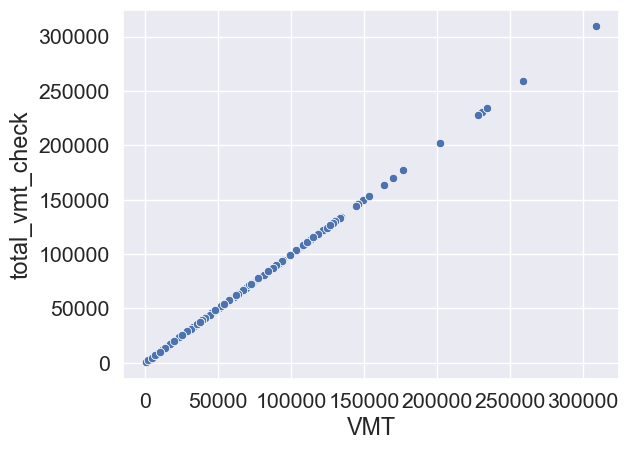

In [9]:
EV_VMT_by_home.loc[:, 'total_vmt_check'] = \
EV_VMT_by_home.loc[:, output_attrs].sum(axis = 1)
EV_VMT_by_home[['VMT', 'total_vmt_check']].head(10)
 

sns.scatterplot(data=EV_VMT_by_home.head(1000), x="VMT", y="total_vmt_check")

In [10]:
EV_VMT_by_home = EV_VMT_by_home.drop(columns = ['total_vmt_check'])
EV_VMT_by_home = EV_VMT_by_home.drop(columns = veh_tech)


EV_VMT_by_home.loc[:, 'ICEV_VMT'] = EV_VMT_by_home.loc[:, 'HEV_Gasoline_VMT'] + \
EV_VMT_by_home.loc[:, 'ICEV_Gasoline_VMT'] + EV_VMT_by_home.loc[:, 'ICEV_NG_VMT'] + \
0.78 * EV_VMT_by_home.loc[:, 'PHEV_25_VMT'] + 0.38 * EV_VMT_by_home.loc[:, 'PHEV_50_VMT'] 

EV_VMT_by_home.loc[:, 'EV_VMT'] = EV_VMT_by_home.loc[:, 'BEV_100_VMT'] + \
EV_VMT_by_home.loc[:, 'BEV_300_VMT'] + EV_VMT_by_home.loc[:, 'FCEV_VMT'] + \
0.22 * EV_VMT_by_home.loc[:, 'PHEV_25_VMT'] + 0.62 * EV_VMT_by_home.loc[:, 'PHEV_50_VMT']

EV_VMT_by_home.to_csv(os.path.join(path_to_vmt, 'home_VMT_by_tech.csv'), 
                      index = False)

In [11]:
# post-process EV ownership
print(len(EV_penetration_by_scenario))
EV_penetration_out = EV_penetration_by_scenario.copy()
EV_penetration_out['home_GEOID'] = \
EV_penetration_out['home_GEOID'].astype(str).str.zfill(11)
for veh in veh_tech:
    EV_penetration_out.loc[:, veh] = \
    EV_penetration_out.loc[:, veh] * EV_penetration_out.loc[:, 'Total']

EV_penetration_out.to_csv(os.path.join(EV_penetration_dir, 'home_veh_by_tech.csv'), 
                      index = False)
EV_penetration_out.head(5)

31198


,State,home_GEOID,BEV_100,BEV_300,FCEV,HEV_Gasoline,ICEV_Gasoline,ICEV_NG,PHEV_25,PHEV_50,Total,Description,Year,Scenario,EV_count
0,AZ,04001942600,29.0,76.0,0.0,7.0,835.0,0.0,0.0,6.0,953,Year 2030 Baseline,2030,Baseline,110
1,AZ,04001942700,88.0,214.0,0.0,38.0,2227.0,0.0,2.0,25.0,2594,Year 2030 Baseline,2030,Baseline,328
2,AZ,04001944000,97.0,273.0,0.0,45.0,2691.0,0.0,2.0,16.0,3124,Year 2030 Baseline,2030,Baseline,387
3,AZ,04001944100,73.0,216.0,0.0,33.0,2164.0,0.0,1.0,7.0,2494,Year 2030 Baseline,2030,Baseline,296
4,AZ,04001944201,49.0,180.0,0.0,25.0,1838.0,8.0,1.0,6.0,2107,Year 2030 Baseline,2030,Baseline,235


In [12]:
# generate VMT by through tract
NAVIGAT_VMT_output = None
grouping_var = ['thru_GEOID', 'populationGroupType', 'is_spillover', 
               'is_intrazonal', 'Description',	'Year',	'Scenario']
path_to_vmt = os.path.join('Input', region_code, 'NAVIGAT')
vmt_folders = os.listdir(path_to_vmt)
for folder in vmt_folders:
    print(folder)
    if folder == '.DS_Store' or folder.endswith('.csv'):
        continue
    path_to_results = os.path.join(path_to_vmt, folder)
    file_name = 'BILDAQ_VMT_by_tract_multistate_spillover.csv'
    vmt_by_state = read_csv(os.path.join(path_to_results, file_name))
    vmt_by_state = vmt_by_state[['thru_GEOID', 'home_GEOID', 
                                 'populationGroupType',	'State', 'VMT']]
    vmt_by_state = vmt_by_state.loc[vmt_by_state['VMT'] > 1] # trim off small VMTs
    vmt_by_state['thru_GEOID'] = \
    vmt_by_state['thru_GEOID'].astype(str).str.zfill(11)
    
    vmt_by_state['home_GEOID'] = \
    vmt_by_state['home_GEOID'].astype(str).str.zfill(11)

    vmt_by_state['thru_state'] = \
    vmt_by_state['thru_GEOID'].str[:2]
    
    vmt_by_state['home_state'] = \
    vmt_by_state['home_GEOID'].str[:2]
    
    vmt_by_state['is_spillover'] = 0
    spillover_indx = (vmt_by_state['thru_state'] != vmt_by_state['home_state'])
    vmt_by_state.loc[spillover_indx, 'is_spillover'] = 1

    vmt_by_state['is_intrazonal'] = 0
    intrazonal_indx = (vmt_by_state['home_GEOID'] == vmt_by_state['thru_GEOID'])
    vmt_by_state.loc[intrazonal_indx, 'is_intrazonal'] = 1
    vmt_by_state = pd.merge(vmt_by_state, EV_penetration_to_match,
                            on = 'home_GEOID', how = 'left')
    output_attrs = []
    for veh in veh_tech:
        out_attr = veh + '_VMT'
        output_attrs.append(out_attr)
        vmt_by_state.loc[:, out_attr] = \
        vmt_by_state.loc[:, veh] * vmt_by_state.loc[:, 'VMT']
    vmt_by_state = vmt_by_state.groupby(grouping_var)[output_attrs].sum()
    vmt_by_state = vmt_by_state.reset_index()
    NAVIGAT_VMT_output = pd.concat([NAVIGAT_VMT_output, vmt_by_state])
    # break

# data need to be regrouped, as spillover may come from multiple states
NAVIGAT_VMT_output = NAVIGAT_VMT_output.groupby(grouping_var)[output_attrs].sum()
NAVIGAT_VMT_output = NAVIGAT_VMT_output.reset_index()
print(len(NAVIGAT_VMT_output))
NAVIGAT_VMT_output.head(5)

UT
MT
.DS_Store
home_VMT_by_tech.csv
CO
CA
WY
NM
NV
AZ
ID
through_VMT_by_tech.csv
OR
WA
274144


,thru_GEOID,populationGroupType,is_spillover,is_intrazonal,Description,Year,Scenario,BEV_100_VMT,BEV_300_VMT,FCEV_VMT,HEV_Gasoline_VMT,ICEV_Gasoline_VMT,ICEV_NG_VMT,PHEV_25_VMT,PHEV_50_VMT
0,04001942600,high-income,0,0,Year 2030 Baseline,2030,Baseline,229.142899,516.880369,0.340108,53.938545,2941.271734,8.420798,6.345634,40.676612
1,04001942600,high-income,0,0,Year 2030 NEVI,2030,NEVI,238.653867,516.544105,0.127838,59.240466,2928.728382,7.633258,4.077580,42.011205
2,04001942600,high-income,0,1,Year 2030 Baseline,2030,Baseline,40.449501,106.005589,0.000000,9.763673,1164.666670,0.000000,0.000000,8.368862
3,04001942600,high-income,0,1,Year 2030 NEVI,2030,NEVI,51.662194,125.664797,0.000000,5.585102,1142.153375,0.000000,0.000000,4.188827
4,04001942600,high-income,1,0,Year 2030 Baseline,2030,Baseline,366.600966,1052.537102,2.810614,140.693481,6110.767922,0.746715,21.322458,62.956039


In [13]:
NAVIGAT_VMT_output.loc[:, 'ICEV_VMT'] = NAVIGAT_VMT_output.loc[:, 'HEV_Gasoline_VMT'] + \
NAVIGAT_VMT_output.loc[:, 'ICEV_Gasoline_VMT'] + NAVIGAT_VMT_output.loc[:, 'ICEV_NG_VMT'] + \
0.78 * NAVIGAT_VMT_output.loc[:, 'PHEV_25_VMT'] + 0.38 * NAVIGAT_VMT_output.loc[:, 'PHEV_50_VMT'] 

NAVIGAT_VMT_output.loc[:, 'EV_VMT'] = NAVIGAT_VMT_output.loc[:, 'BEV_100_VMT'] + \
NAVIGAT_VMT_output.loc[:, 'BEV_300_VMT'] + NAVIGAT_VMT_output.loc[:, 'FCEV_VMT'] + \
0.22 * NAVIGAT_VMT_output.loc[:, 'PHEV_25_VMT'] + 0.62 * NAVIGAT_VMT_output.loc[:, 'PHEV_50_VMT']

NAVIGAT_VMT_output.to_csv(os.path.join(path_to_vmt, 'through_VMT_by_tech.csv'), 
                      index = False)

In [13]:
# assembly final output
# select census tract in WECC region
state_id_lookup_WECC = state_id_lookup[['GEOID', 'fips_st',
       'st_code', 'state', 'cty', 'ctyname', 'geotype', 'microtype']]
state_id_lookup_WECC = \
state_id_lookup_WECC.loc[state_id_lookup_WECC['st_code'].isin(WECC_states)]

print(len(state_id_lookup_WECC))

state_id_lookup_WECC['GEOID'] = \
state_id_lookup_WECC['GEOID'].astype(str).str.zfill(11)
# append EV ownership
state_id_lookup_WECC = pd.merge(state_id_lookup_WECC,
                                EV_penetration_out,
                                left_on = 'GEOID',
                                right_on = 'home_GEOID',
                                how = 'left')
print(len(state_id_lookup_WECC))
state_id_lookup_WECC.head(5)

15570


NameError: name 'EV_penetration_out' is not defined

# Part 3 -- assign power plant location to tracts

In [4]:
WECC_states = ['AZ', 'CA', 'CO', 'ID', 'MT',
               'NM', 'NV', 'OR', 'UT', 'WA', 'WY']


print(len(power_plant_location))
power_plant_location = power_plant_location.drop_duplicates(subset = ['Unique ID'],
                                                           keep = 'first')
print(len(power_plant_location))
power_plant_location.head(5)

25976
4597


,LAT,LON,Unique ID
0,25.4356,-80.3308,621
1,25.4756,-80.4700,665
2,25.9131,-97.5214,3559
3,26.0686,-80.1984,613
4,26.2080,-98.3992,55098


<Axes: >

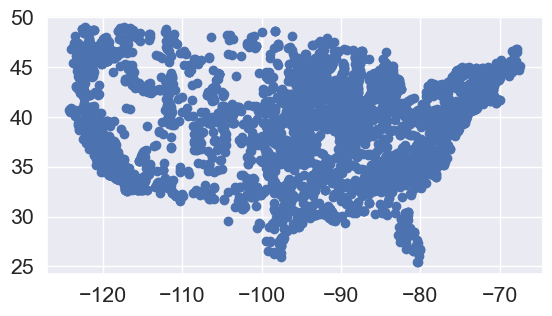

In [7]:
# convert coordinates to GPD points
# X=LON, Y=LAT
power_plant_location.loc[:, 'geometry'] = \
gpd.points_from_xy(power_plant_location.LON, power_plant_location.LAT, crs="EPSG:4326")
power_plant_location_gdf = gpd.GeoDataFrame(power_plant_location, geometry='geometry')
power_plant_location_gdf.plot()

In [19]:
# load balance area
balance_file = 'Network/from_mcgrid/inputs_generators_BA.csv'
grid_balance_area = read_csv(balance_file)
# grid_balance_area.plot()
grid_balance_area.head(5)

,RegionName,FuelType,FuelCostTotal,PLCO2RTA,ramp,ORISCode,DIVISIONCE,UNITID,Capacity,OBJECTID,...,generationCO2,g,OBJECTID_1,Balancing_Area,st,rto,interconne,country,custreg,Index_
0,ERC_FRNT,NaturalGas,19.440628,892.0,0.8,55062,WSC-TX,GTG1,155.0,12038,...,892.0,1,116,64,tx,rto10,texas,usa,South Central,1
1,ERC_FRNT,NaturalGas,19.440628,892.0,0.8,55062,WSC-TX,GTG2,155.0,12037,...,892.0,1,116,64,tx,rto10,texas,usa,South Central,2
2,ERC_FRNT,NaturalGas,19.440628,892.0,0.8,55062,WSC-TX,GTG3,155.0,12040,...,892.0,1,116,64,tx,rto10,texas,usa,South Central,3
3,ERC_FRNT,NaturalGas,19.440628,892.0,0.8,55062,WSC-TX,STG1,395.0,12039,...,892.0,1,116,64,tx,rto10,texas,usa,South Central,4
4,ERC_GWAY,NaturalGas,19.440628,870.0,0.8,55132,WSC-TX,GTG1,152.0,12185,...,870.0,2,115,63,tx,rto10,texas,usa,South Central,5


In [25]:
# assign power plant to census tract
data_crs = power_plant_location_gdf.crs
us_tracts_geojson = us_tracts_geojson.to_crs(data_crs)
power_plant_to_tract = power_plant_location_gdf.sjoin(us_tracts_geojson, how="left")
print(len(power_plant_to_tract))

power_plant_to_tract.head(5)
      

4597


,LAT,LON,Unique ID,geometry,index_right,GEOID,NAME,home_GEOID
0,25.4356,-80.3308,621,POINT (-80.33080 25.43560),16536,12086011401,"Census Tract 114.01, Miami-Dade County, Florida",12086011401
1,25.4756,-80.4700,665,POINT (-80.47000 25.47560),16531,12086011101,"Census Tract 111.01, Miami-Dade County, Florida",12086011101
2,25.9131,-97.5214,3559,POINT (-97.52140 25.91310),62357,48061012800,"Census Tract 128, Cameron County, Texas",48061012800
3,26.0686,-80.1984,613,POINT (-80.19840 26.06860),14677,12011110600,"Census Tract 1106, Broward County, Florida",12011110600
4,26.2080,-98.3992,55098,POINT (-98.39920 26.20800),64857,48215024204,"Census Tract 242.04, Hidalgo County, Texas",48215024204


In [26]:
# aassign state and county id
power_plant_to_tract['GEOID'] = power_plant_to_tract['GEOID'].astype(str).str.zfill(11)

state_id_lookup_short = state_id_lookup[['GEOID', 'st_code', 'cty',	'ctyname']]
state_id_lookup_short = state_id_lookup_short.drop_duplicates(keep = 'first')
state_id_lookup_short['GEOID'] = state_id_lookup_short['GEOID'].astype(str).str.zfill(11)

power_plant_to_tract = pd.merge(power_plant_to_tract,
                                state_id_lookup_short,
                                on = 'GEOID', how = 'left')
power_plant_to_tract = \
power_plant_to_tract[['LAT', 'LON','Unique ID',	'GEOID', 'NAME', 'st_code',	'cty', 'ctyname']]
print(len(power_plant_to_tract))
power_plant_to_tract.head(5)

4597


,LAT,LON,Unique ID,GEOID,NAME,st_code,cty,ctyname
0,25.4356,-80.3308,621,12086011401,"Census Tract 114.01, Miami-Dade County, Florida",FL,12086,"Miami-Dade County, FL"
1,25.4756,-80.4700,665,12086011101,"Census Tract 111.01, Miami-Dade County, Florida",FL,12086,"Miami-Dade County, FL"
2,25.9131,-97.5214,3559,48061012800,"Census Tract 128, Cameron County, Texas",TX,48061,"Cameron County, TX"
3,26.0686,-80.1984,613,12011110600,"Census Tract 1106, Broward County, Florida",FL,12011,"Broward County, FL"
4,26.2080,-98.3992,55098,48215024204,"Census Tract 242.04, Hidalgo County, Texas",TX,48215,"Hidalgo County, TX"


In [32]:
# assign balance area
grid_balance_area.columns
grid_balance_area_short = \
grid_balance_area[['ORISCode', 'StateName', 
                   'NERC', 'SUBRGN', 'Balancing_Area']]

grid_balance_area_short = \
grid_balance_area_short.rename(columns = {'ORISCode': 'Unique ID'})
grid_balance_area_short = grid_balance_area_short.drop_duplicates(keep = 'first')
power_plant_to_tract_bal = pd.merge(power_plant_to_tract,
                                    grid_balance_area_short,
                                    on = 'Unique ID',
                                    how = 'left')
print(len(power_plant_to_tract_bal))
power_plant_to_tract_bal.head(5)

4597


,LAT,LON,Unique ID,GEOID,NAME,st_code,cty,ctyname,StateName,NERC,SUBRGN,Balancing_Area
0,25.4356,-80.3308,621,12086011401,"Census Tract 114.01, Miami-Dade County, Florida",FL,12086,"Miami-Dade County, FL",Florida,FRCC,FRCC,102
1,25.4756,-80.4700,665,12086011101,"Census Tract 111.01, Miami-Dade County, Florida",FL,12086,"Miami-Dade County, FL",Florida,FRCC,FRCC,102
2,25.9131,-97.5214,3559,48061012800,"Census Tract 128, Cameron County, Texas",TX,48061,"Cameron County, TX",Texas,TRE,ERCT,65
3,26.0686,-80.1984,613,12011110600,"Census Tract 1106, Broward County, Florida",FL,12011,"Broward County, FL",Florida,FRCC,FRCC,102
4,26.2080,-98.3992,55098,48215024204,"Census Tract 242.04, Hidalgo County, Texas",TX,48215,"Hidalgo County, TX",Texas,TRE,ERCT,65


In [33]:
# check duplicates
# print(power_plant_to_tract_bal.duplicated(subset=['Unique ID']))
id_with_dup = \
power_plant_to_tract_bal.loc[power_plant_to_tract_bal.duplicated(subset=['Unique ID']), 'Unique ID'].unique() 
power_plant_dup = \
power_plant_to_tract_bal.loc[power_plant_to_tract_bal['Unique ID'].isin(id_with_dup)]
power_plant_dup

,LAT,LON,Unique ID,GEOID,NAME,st_code,cty,ctyname,StateName,NERC,SUBRGN,Balancing_Area


In [34]:
power_plant_to_tract_bal.to_csv('Network/from_mcgrid/power_plant_by_tracts_bal.csv', index = False)